In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

Mounted at /content/gdrive


# **DATA ANALYSIS AND CLEANUP**

In [2]:
def load_credit_data(data_path):
    return(pd.read_csv(data_path,index_col=0))

data_path = '/content/gdrive/My Drive/FoodPanda-TakeHome'
training_data_path = os.path.join(data_path,'data/cs-training.csv')
training_df = load_credit_data(training_data_path)

training_df.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


SeriousDlqin2yrs
0    139974
1     10026
dtype: int64

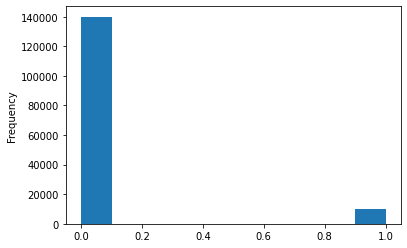

In [3]:
#check dataset balance
training_df['SeriousDlqin2yrs'].plot(kind='hist')    
training_df.groupby('SeriousDlqin2yrs').size()

1. Based on the above output, we can see the dataset is skewed due to the higher number of non-defaulters.
2. I intend to balance the dataset by upsampling the defaulter rows in order to achieve a better balance. The code for upsampling can be found in the model training section.

In [4]:
# Check Column 2 - RevolvingUtilizationOfUnsecuredLines
print(training_df['RevolvingUtilizationOfUnsecuredLines'].describe())
print("Number of rows with RevolvingUtilizationOfUnsecuredLines > 10 is {}".format(training_df[training_df['RevolvingUtilizationOfUnsecuredLines']>10].count()['RevolvingUtilizationOfUnsecuredLines']))
print("Number of rows with missing RevolvingUtilizationOfUnsecuredLines value is {}".format(training_df['RevolvingUtilizationOfUnsecuredLines'].isnull().sum()))

#There are no missing values in this column, so we will directly replace values above 10 with the median.
training_df['RevolvingUtilizationOfUnsecuredLines'] = training_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: training_df['RevolvingUtilizationOfUnsecuredLines'].median() if x>10 else x)
print(training_df['RevolvingUtilizationOfUnsecuredLines'].describe())

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
Number of rows with RevolvingUtilizationOfUnsecuredLines > 10 is 241
Number of rows with missing RevolvingUtilizationOfUnsecuredLines value is 0
count    150000.000000
mean          0.322487
std           0.366515
min           0.000000
25%           0.029867
50%           0.154178
75%           0.555149
max           8.851852
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


1. In case of RevolvingUtilizationOfUnsecuredLines, I noticed that there are quite a lot of values > 1 although it is a percentage column. Based on some research online and also in the discussion page, I understand that there could be scenarios when the value could be > 1 especially when the balance can be greater than the limits and these could indicate fraudulent activity as well. While this is possible, I still have kept a higher limit of 10 since values such as 50708 seem quite unrealistic.
2. There are  200+ records with a value > 10 and I will replace these values with the median of the column values.


In [5]:
# Check column 3 - Age
print(training_df.groupby('age').size())

print("Number of rows with Age > 100 is {}".format(training_df[training_df['age']>100].count()['age']))
print("Number of rows with missing Age value is {}".format(training_df['age'].isnull().sum()))

training_df['age'] = training_df['age'].apply(lambda x: training_df['age'].median() if x==0 else x)
#training_df['age'] = training_df['age'].apply(lambda x: 99 if x>=100 else x)

print(training_df['age'].describe())

age
0        1
21     183
22     434
23     641
24     816
      ... 
102      3
103      3
105      1
107      1
109      2
Length: 86, dtype: int64
Number of rows with Age > 100 is 13
Number of rows with missing Age value is 0
count    150000.000000
mean         52.295553
std          14.771249
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64


1. Based on the distribution, there is 1 record with age as 0 and 13 records with age > 100. 
2. In case of age=0, we can conclude that it is invalid and hence, I replace it with the median of the age column.
3. In case of ages > 100, I retained them since there are very few records and occasionally, such ages could be valid. Further, the age is capped at 109 and values do not reach unrealistic numbers > 120 or so.

NumberOfTime30-59DaysPastDueNotWorse
0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
dtype: int64
Number of rows with missing NumberOfTime30-59DaysPastDueNotWorse value is 0


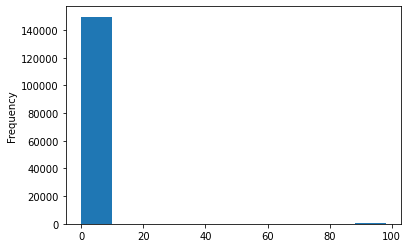

In [6]:
# Check column 4 - NumberOfTime30-59DaysPastDueNotWorse
print(training_df.groupby('NumberOfTime30-59DaysPastDueNotWorse').size())

training_df['NumberOfTime30-59DaysPastDueNotWorse'].plot(kind='hist')

print("Number of rows with missing NumberOfTime30-59DaysPastDueNotWorse value is {}".format(training_df['NumberOfTime30-59DaysPastDueNotWorse'].isnull().sum()))
#training_df['NumberOfTime30-59DaysPastDueNotWorse'] = training_df['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: training_df['NumberOfTime30-59DaysPastDueNotWorse'].median() if (x==96 or x==98)  else x)

#print(training_df.groupby('NumberOfTime30-59DaysPastDueNotWorse').size())

1. As we can see in the counts as well as in the histogram plot, there are about 200+ records with values of 96 or 98. Based on the Kaggle discussion, I understand that 96 or 98 could be coded values that may correspond to - Do not want to answer or missing/other values.
2. My initial step was to replace these values with the median of the column since these values might not be relevant.
3. When I tested my final model on the test dataset, I got an AUC score of 0.86739.
4. I later removed the imputation for the coded values since I thought that these values could carry some meaning with regards to the target variable and decided to let the model learn from these values without changing them.
5. I observed the validation AUC score improved and then when I used on the final test dataset, the auc increased from 0.86739 to 0.86826 (Ranked around 43 in the private dashboard).

[]
Number of rows with missing MonthlyIncome value is 0
Number of rows with missing MonthlyIncome value is 0
MonthlyIncome
2.0          6
4.0          2
5.0          2
7.0          1
9.0          1
            ..
835040.0     1
1072500.0    1
1560100.0    1
1794060.0    1
3008750.0    1
Length: 13592, dtype: int64


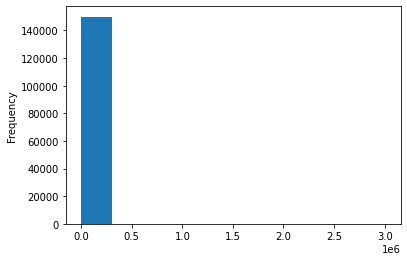

In [8]:
# Check column 6 -  Monthly Income first since Column 5 Debt Ratio is divided by the MonthlyIncome and hence depends on the new imputed values
imputed_indices = training_df[(training_df['MonthlyIncome'].isnull()) | (training_df['MonthlyIncome']==0) | (training_df['MonthlyIncome']==1)].index.tolist()
print(imputed_indices)
print("Number of rows with missing MonthlyIncome value is {}".format(training_df['MonthlyIncome'].isnull().sum()))
print("Number of rows with missing MonthlyIncome value is {}".format(training_df[training_df['MonthlyIncome']==0].count()['DebtRatio']))

training_df['MonthlyIncome'] = training_df['MonthlyIncome'].apply(lambda x: training_df['MonthlyIncome'].median() if (x==0 or x==1) else x)
training_df['MonthlyIncome'].fillna((training_df['MonthlyIncome'].median()), inplace=True)

print(training_df.groupby('MonthlyIncome').size())

#training_df.DebtRatio.unique()

training_df['MonthlyIncome'].plot(kind='hist')


1. In the Monthly Income column, I observed several missing values (29731) or values with 0 (1634) in them or 1 (615) in them.
2. Interestingly, I also observed that when the values were missing or 0 or 1 in the Monthly Income column, the corresponding DebtRatio values were extremely high and it is possible that the Debts were divided by a dummy value of 1 in order to avoid divide by 0 errors.
3. I did not change the monthly income values from 2 onwards or even records with very high unrealistic values because these were extremely few records and I believe that the dataset is large enough to handle such cases.
4. Only in the case of missing, 0 or 1 monthly income values, I imputed them with the median value.
5. The reason as to why I replaced records with monthly income 1 with the median but not monthly income 2 onwards is because there were 615 records with 1 income but very few records from 2 (6 records or so) onwards. I felt that this was strange and therefore assumed that 1 might also be an erroneous case.

In [9]:
# Check Column 5 - Debt Ratio. Imputing values at locations where MonthlyIncome was imputed

print("Number of rows with missing DebtRatio value is {}".format(training_df['DebtRatio'].isnull().sum()))
training_df[training_df['MonthlyIncome'].isnull()].groupby('DebtRatio').size()
training_df.loc[imputed_indices,'DebtRatio']=training_df['DebtRatio']/training_df['MonthlyIncome']
training_df['DebtRatio'].describe()

Number of rows with missing DebtRatio value is 0


count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

1. Since debt ratio is calculated as ratio between debts and monthly income, I imputed new values only at the locations where monthly income was imputed in the previous cell.
2. Once again, there are few very high large values in debt ratio as well but since I left the monthly income as is, I did not alter the debt ratios as well.

Number of rows with missing NumberOfOpenCreditLinesAndLoans value is 0


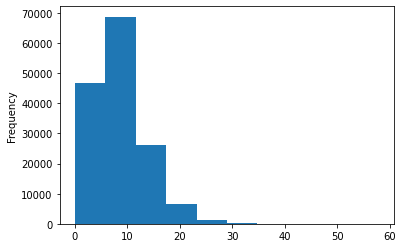

In [10]:
# Check Column 7 - NumberOfOpenCreditLinesAndLoans - No imputation needed
print("Number of rows with missing NumberOfOpenCreditLinesAndLoans value is {}".format(training_df['NumberOfOpenCreditLinesAndLoans'].isnull().sum()))
training_df['NumberOfOpenCreditLinesAndLoans'].describe()
training_df['NumberOfOpenCreditLinesAndLoans'].plot(kind='hist')

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
dtype: int64
Number of rows with missing NumberOfTimes90DaysLate value is 0


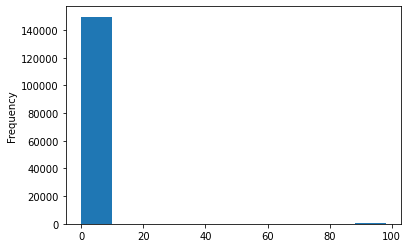

In [11]:
#Check Column 8 - NumberOfTimes90DaysLate

print(training_df.groupby('NumberOfTimes90DaysLate').size())
print("Number of rows with missing NumberOfTimes90DaysLate value is {}".format(training_df['NumberOfTimes90DaysLate'].isnull().sum()))

training_df['NumberOfTimes90DaysLate'].plot(kind='hist')
#training_df['NumberOfTimes90DaysLate'] = training_df['NumberOfTimes90DaysLate'].apply(lambda x: training_df['NumberOfTimes90DaysLate'].median() if (x==96 or x==98)  else x)



1. Once again, I removed the imputation logic in this cell since the model works better when we retain coded values, 96 and 98.

NumberRealEstateLoansOrLines
0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
18        2
19        2
20        2
21        1
23        2
25        3
26        1
29        1
32        1
54        1
dtype: int64
Number of rows with missing NumberRealEstateLoansOrLines value is 0


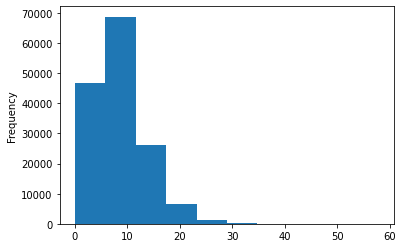

In [12]:
#Check Column 9 - NumberRealEstateLoansOrLines - No imputation needed

print(training_df.groupby('NumberRealEstateLoansOrLines').size())
training_df['NumberOfOpenCreditLinesAndLoans'].plot(kind='hist')
print("Number of rows with missing NumberRealEstateLoansOrLines value is {}".format(training_df['NumberRealEstateLoansOrLines'].isnull().sum()))


NumberOfTime60-89DaysPastDueNotWorse
0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
dtype: int64
Number of rows with missing NumberOfTime60-89DaysPastDueNotWorse value is 0


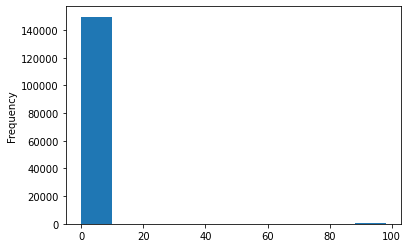

In [13]:
#Check Column 10 - NumberOfTime60-89DaysPastDueNotWorse

print(training_df.groupby('NumberOfTime60-89DaysPastDueNotWorse').size())
print("Number of rows with missing NumberOfTime60-89DaysPastDueNotWorse value is {}".format(training_df['NumberOfTime60-89DaysPastDueNotWorse'].isnull().sum()))

training_df['NumberOfTime60-89DaysPastDueNotWorse'].plot(kind='hist')
#training_df['NumberOfTime60-89DaysPastDueNotWorse'] = training_df['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: training_df['NumberOfTime60-89DaysPastDueNotWorse'].median() if (x==96 or x==98)  else x)



1. Once again, I removed the imputation logic in this cell since the model works better when we retain coded values, 96 and 98.

NumberOfDependents
0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
dtype: int64
Number of rows with missing NumberOfDependents value is 3924


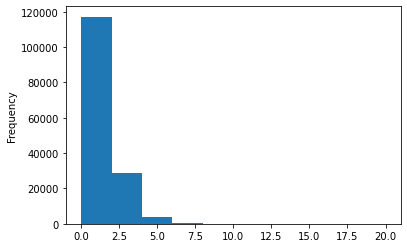

In [14]:
#Check Column 11 - NumberOfDependents

print(training_df.groupby('NumberOfDependents').size())
print("Number of rows with missing NumberOfDependents value is {}".format(training_df['NumberOfDependents'].isnull().sum()))
training_df['NumberOfDependents'].fillna((training_df['NumberOfDependents'].median()), inplace=True)

training_df['NumberOfDependents'].plot(kind='hist')


1. For number of dependents, I removed only the values which were NA and I retained the rest of the records without any imputation.

In [15]:
training_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.322487,52.295553,0.421033,353.005076,6.499055e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,0.366515,14.771249,4.192781,2037.818523,1.286687e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,21.000000,0.000000,0.000000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,4.000000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154178,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.555149,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,8.851852,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


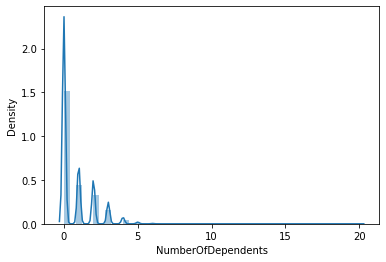

In [96]:
#sns.distplot(training_df['NumberOfOpenCreditLinesAndLoans'])
sns.distplot(training_df['NumberOfDependents'])

# **MODEL TRAINING**

### CREATING TRAINING DATA

In [16]:
from imblearn.over_sampling import RandomOverSampler

labels = np.array(training_df['SeriousDlqin2yrs'])
features= training_df.drop('SeriousDlqin2yrs', axis = 1)
features = np.array(features)

oversample = RandomOverSampler(sampling_strategy='minority')
features_os,labels_os=oversample.fit_resample(features,labels)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1. Since we have the training data cleaned and ready, the first step is to separate out the features and the target labels.
2. In the second step, I apply oversampling of the minority class (delinquent records) in order to fix the dataset imbalance that was highlighted in the beginning.
3. In order to do dataset balancing, I tried out a couple of different techniques and finally relied on simple naive random oversampling of the minority class which gave me the best results.
4. Firstly, I verified the performance of different models without any dataset balancing and measured the AUC. 
5. Then I tried to use SMOTE oversampling (Synthetic Minority Oversampling Technique) which was fairly new to me as well and I measured the AUC validation performance which had dropped lower than earlier. I tried to understand why this may be happening and my hypothesis is that this may be due to overlapping classes during which SMOTE might not work well. This is because SMOTE uses KNN in order to identify neighbours and then generates synthetic records with this neighbour.
6. SMOTE does not take into account the actual class of the neighbouring record.
7. Hence I decided to use Random Oversampling provided by the same library and observed the performance to be much better. (>0.86)

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[200,400,600,800,1000,1200]
min_samples_leaf=[1,2,4]

rf=RandomForestClassifier()
random_grid = {'rf__n_estimators': n_estimators,
               'rf__min_samples_leaf': min_samples_leaf}

print(random_grid)
model = Pipeline([
        ('sampling', RandomOverSampler(sampling_strategy='minority')),
        ('rf', rf)
    ])

rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 4, n_iter=10,verbose=2, random_state=42)
rf_random.fit(features, labels)
rf_random.best_params_'''


## MODELS USED

1. Random Forest Classifier
2. Gradient Boosting Classifier
3. VotingClassifier with both Random Forest and Gradient Boosting Classifiers

Based on performance, final chosen model was VotingClassifier which uses both RandomForest and GradientBoosting classifiers.

**HYPERPARAMETER TUNING**

1. Ideally, I would like to use the above code in order to a RandomizedSearchCV in order to find the best hyperparameters. However, GridSearch or RandomizedSearchCV take quite a long time for execution and in the interest of time, I tried a few hyperparameters in each classifier with different values by trial and error and chose the one which gave me the best performance on the validation set.
2. For ex: I tried the GradientBoostingClassifier with different no. of trees such as 100,200,300...Based on the AUC on the validation set, I saw that beyond 200 trees, the model overfits the dataset given the values of the other hyperparameters.
2. However, I have still retained the code written for RandomizedSearchCV for hyperparamter tuning which internally uses Stratified-KFold for validation.

In [ ]:
'''from sklearn.ensemble import GradientBoostingClassifier 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[200,400,600,800,1000,1200]
learning_rate=[0.2,0.3,0.4,None]
subsample=[0.8,0.9,None]

gbc=GradientBoostingClassifer()
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample':subsample}

print(random_grid)
model = Pipeline([
        ('sampling', RandomOverSampler(sampling_strategy='minority')),
        ('gbc', gbc)
    ])

gbc_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 4, n_iter=10,verbose=1, random_state=42, n_jobs = -1)
gbc_random.fit(features, labels)
gbc_random.best_params_'''

## RANDOM FOREST CLASSIFIER

1. In the below cell, I am training a Random Forest Classifier after choosing hyperparameters based on few trial and error runs as explained earlier. 

## VALIDATION TECHNIQUE
2. In order to validate the model, I perform StratifiedKFold validation with 4 splits.
3. The reason I use this technique is because it helps give a better idea of how generalized the model is compared to a standard train-test split. 
4. Sometimes, it is possible that in the train-test split, the validation set had a lot of easy examples due to which the model performed well on it and hence the performance isn't an accurate reflection of the model. In other words, the validation set doesn't fully represent the actual unseen data.
5. Alternately, in K-fold, the dataset is divided into a given number of splits out of which 1 split is used as the validation set in one iteration. In the next iteration, another split is used as the validation set.
6. In the process, each sample is used as training data 4 times in my case and as test data one time. Therefore, the model is able to see the entire training data and also test on different parts of the data. If the model is generalized, then the performance across each validation set will be stable without too much variance.
7. If the model is not generalized, it may perform well on one split and perform poorly on the other split, which will help us identify that an issue needs to be addressed.
8. StratifiedKFold is used to ensure the validation set and training sets are representative of the overall dataset by maintain same ratio of classes. It would be even more useful when there is a dataset imbalance but in this case since we use oversampling, there is no imbalance.
9. The oversampling in this case is being done using the training data within each split as part of the KFoldCV and not before. If we do oversampling earlier, the model will already remember some of the duplicated records and hence overfit.

(112500,)
(37500,)
(209962, 10)
(209962,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished


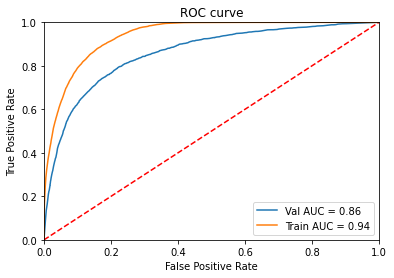

(112500,)
(37500,)
(209962, 10)
(209962,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.5s finished


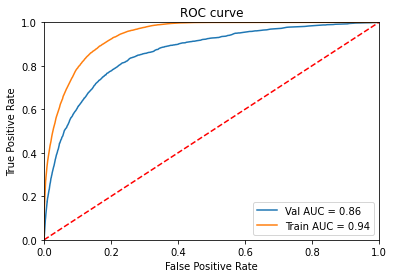

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(112500,)
(37500,)
(209960, 10)
(209960,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.5s finished


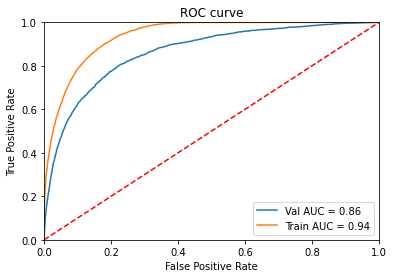

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(112500,)
(37500,)
(209960, 10)
(209960,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished


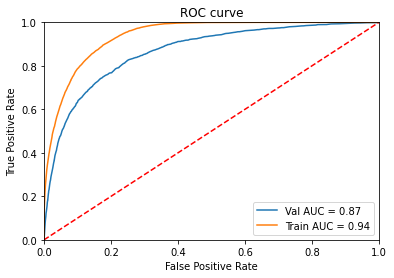

Mean of the Training AUC after k-fold cross validation is: 0.9393872843489824
Mean of the Val AUC after k-fold cross validation is: 0.8622977279226591


In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

kf = StratifiedKFold(n_splits=4)
auc=[]
auc_train=[]
for train_index, test_index in kf.split(features,labels):
  rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_samples=5000, verbose=1, max_features='sqrt')
  print(train_index.shape)
  print(test_index.shape)
  features_train, features_test = features[train_index], features[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]
  oversample = RandomOverSampler(sampling_strategy='minority')
  features_train_oversampled, labels_train_oversampled = oversample.fit_resample(features_train, labels_train)
  print(features_train_oversampled.shape)
  print(labels_train_oversampled.shape)

  rf.fit(features_train_oversampled, labels_train_oversampled);

  train_predictions = np.array(rf.predict_proba(features_train_oversampled)[:,1])
  fpr_train, tpr_train, thresholds_train = metrics.roc_curve(labels_train_oversampled, train_predictions)
  roc_auc_train=metrics.auc(fpr_train, tpr_train)
  auc_train.append(roc_auc_train)

  predictions = np.array(rf.predict_proba(features_test)[:,1])

  fpr, tpr, thresholds = metrics.roc_curve(labels_test, predictions)
  roc_auc=metrics.auc(fpr, tpr)
  auc.append(roc_auc)
  plt.title('ROC curve')
  plt.plot(fpr, tpr, label = 'Val AUC = %0.2f' % roc_auc)
  plt.plot(fpr_train,tpr_train,label='Train AUC = %0.2f' % roc_auc_train)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

print("Mean of the Training AUC after k-fold cross validation is:", np.mean(auc_train))
print("Mean of the Val AUC after k-fold cross validation is:", np.mean(auc))

In [44]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_samples=5000, verbose=1, max_features='sqrt')
rf.fit(features_os,labels_os)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

## **PREPARING TEST DATA**

1. In this case, I am carrying out the same imputation or cleaning steps on the test data that I used in the training dataset.
2. Essentially, I impute the test data (if there are missing values or in case of fields such RevolvingUtilizationOfUnsecuredLines > 10, age = 0, monthly income missing or 0 or 1 etc) with the median of the TRAINING DATA.
3. This is because if model receives data in real-time, we will not have access to the entire test data to be able to use the test data's median.
4. I tested my models by imputing the training data median into the test data for the concerned fields and achieved highest AUC of 0.86766 (Ranked around 70)
5. If I consider that the entire test data is available and use the test data median to impute values in test data, I achieved a highest AUC of 0.86836 (Ranked around 40)
6. From the perspective of the competition, I suppose we can use method 5 as well but in general point 4 might be more suitable.

In [27]:
testing_data_path = os.path.join(data_path,'data/cs-test.csv')
testing_df = load_credit_data(testing_data_path)

testing_df.head()


testing_df['RevolvingUtilizationOfUnsecuredLines'] = testing_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: training_df['RevolvingUtilizationOfUnsecuredLines'].median() if x>10 else x)
testing_df['age'] = testing_df['age'].apply(lambda x: training_df['age'].median() if x==0 else x)
#testing_df['NumberOfTime30-59DaysPastDueNotWorse'] = testing_df['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: testing_df['NumberOfTime30-59DaysPastDueNotWorse'].median() if (x==96 or x==98)  else x)

imputed_indices = testing_df[(testing_df['MonthlyIncome'].isnull()) | (testing_df['MonthlyIncome']==0) | (testing_df['MonthlyIncome']==1)].index.tolist()
testing_df['MonthlyIncome'] = testing_df['MonthlyIncome'].apply(lambda x: training_df['MonthlyIncome'].median() if (x==0 or x==1) else x)
testing_df['MonthlyIncome'].fillna((training_df['MonthlyIncome'].median()), inplace=True)

testing_df.loc[imputed_indices,'DebtRatio']=testing_df['DebtRatio']/testing_df['MonthlyIncome']

#testing_df['NumberOfTimes90DaysLate'] = testing_df['NumberOfTimes90DaysLate'].apply(lambda x: testing_df['NumberOfTimes90DaysLate'].median() if (x==96 or x==98)  else x)
#testing_df['NumberOfTime60-89DaysPastDueNotWorse'] = testing_df['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: testing_df['NumberOfTime60-89DaysPastDueNotWorse'].median() if (x==96 or x==98)  else x)
testing_df['NumberOfDependents'].fillna((training_df['NumberOfDependents'].median()), inplace=True)

testing_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,0.0,101503.000000,101503.000000,101503.000000,101503.000000,1.015030e+05,101503.000000,101503.000000,101503.000000,101503.000000,101503.00000
mean,NaN,0.323371,52.405436,0.453770,0.415819,6.642774e+03,8.453514,0.296691,1.013074,0.270317,0.74915
std,NaN,0.367142,14.779756,4.538487,6.359936,3.269003e+04,5.144100,4.515859,1.110253,4.503578,1.12860
min,NaN,0.000000,21.000000,0.000000,0.000000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000
25%,NaN,0.030131,41.000000,0.000000,0.114259,4.000000e+03,5.000000,0.000000,0.000000,0.000000,0.00000
50%,NaN,0.152586,52.000000,0.000000,0.277222,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.00000
75%,NaN,0.560359,63.000000,0.000000,0.461855,7.374000e+03,11.000000,0.000000,2.000000,0.000000,1.00000
max,NaN,8.601990,104.000000,98.000000,1382.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.00000


In [160]:
test_features= testing_df.drop('SeriousDlqin2yrs', axis = 1)
test_features = np.array(test_features)

final_predictions=np.array(rf.predict_proba(test_features)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.3s finished


[0.26118724 0.11870416 0.0923687  0.12980948 0.11000667 0.08272206
 0.08599939 0.03719432 0.04731971 0.03468826]
Feature: 0, Score: 0.26119
Feature: 1, Score: 0.11870
Feature: 2, Score: 0.09237
Feature: 3, Score: 0.12981
Feature: 4, Score: 0.11001
Feature: 5, Score: 0.08272
Feature: 6, Score: 0.08600
Feature: 7, Score: 0.03719
Feature: 8, Score: 0.04732
Feature: 9, Score: 0.03469


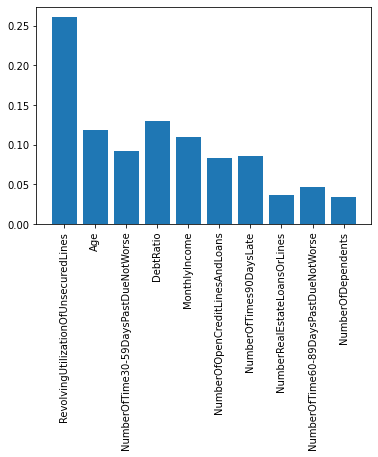

In [45]:
feature_importances = rf.feature_importances_
print(feature_importances)
for i,v in enumerate(feature_importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
feature_list=['RevolvingUtilizationOfUnsecuredLines','Age','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate',
               'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

plt.bar([x for x in feature_list], feature_importances)
plt.xticks(rotation='vertical')
plt.show()


# RESULTS OF RANDOM FOREST CLASSIFIER 
1. Impute test data median into the test set - AUC of 0.86682
2. Impute training data median into test set - AUC of 0.86560

In [161]:
print(final_predictions)
final_df = pd.DataFrame(final_predictions, columns = ['Probability'])
final_df['Id'] = final_df.index + 1

final_df.to_csv('results.csv',index=False)

[0.49  0.372 0.086 ... 0.01  0.498 0.284]


# **GRADIENT BOOSTING CLASSIFIER**

1. Similar to RandomForest, I used trial and error to choose hyperparameters for Gradient Boosting as well.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


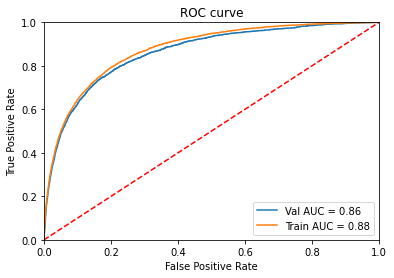

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


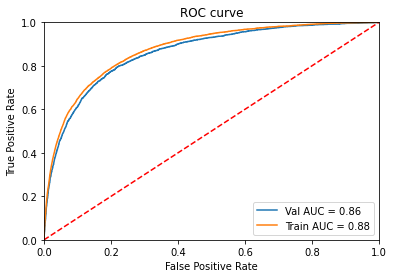

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


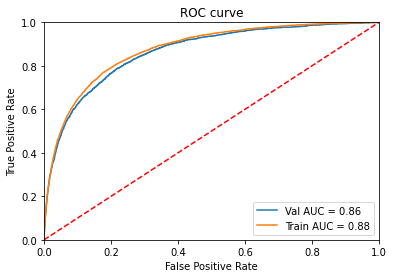

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


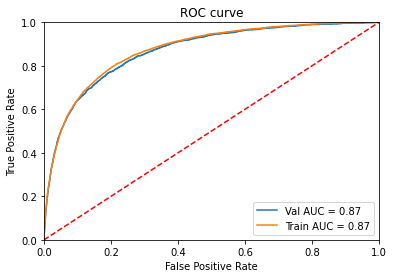

Mean of the Training AUC after k-fold cross validation is: 0.8755943439052742
Mean of the Val AUC after k-fold cross validation is: 0.8646945585206309


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
kf = StratifiedKFold(n_splits=4)
auc_train=[]
auc=[]
for train_index, test_index in kf.split(features,labels):
  gbc = GradientBoostingClassifier(n_estimators=200,max_features='sqrt')
  features_train, features_test = features[train_index], features[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]
  oversample = RandomOverSampler(sampling_strategy='minority')
  features_train_oversampled, labels_train_oversampled = oversample.fit_resample(features_train, labels_train)
    
  gbc.fit(features_train_oversampled, labels_train_oversampled);

  train_predictions = np.array(gbc.predict_proba(features_train_oversampled)[:,1])
  fpr_train, tpr_train, thresholds_train = metrics.roc_curve(labels_train_oversampled, train_predictions)
  roc_auc_train=metrics.auc(fpr_train, tpr_train)
  auc_train.append(roc_auc_train)

  predictions = np.array(gbc.predict_proba(features_test)[:,1])
  fpr, tpr, thresholds = metrics.roc_curve(labels_test, predictions)
  roc_auc=metrics.auc(fpr, tpr)
  auc.append(roc_auc)

  plt.title('ROC curve')
  plt.plot(fpr, tpr, label = 'Val AUC = %0.2f' % roc_auc)
  plt.plot(fpr_train,tpr_train,label='Train AUC = %0.2f' % roc_auc_train)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

print("Mean of the Training AUC after k-fold cross validation is:", np.mean(auc_train))
print("Mean of the Val AUC after k-fold cross validation is:", np.mean(auc))

In [38]:
gbc = GradientBoostingClassifier(n_estimators=200,max_features='sqrt')
gbc.fit(features_os,labels_os)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[0.38733436 0.04594158 0.18375079 0.01733231 0.01867537 0.01952456
 0.17040822 0.01624443 0.13736577 0.00342261]
Feature: 0, Score: 0.38733
Feature: 1, Score: 0.04594
Feature: 2, Score: 0.18375
Feature: 3, Score: 0.01733
Feature: 4, Score: 0.01868
Feature: 5, Score: 0.01952
Feature: 6, Score: 0.17041
Feature: 7, Score: 0.01624
Feature: 8, Score: 0.13737
Feature: 9, Score: 0.00342


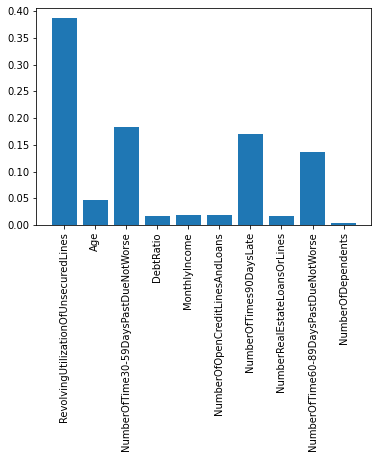

In [39]:
feature_importances = gbc.feature_importances_
print(feature_importances)
for i,v in enumerate(feature_importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
feature_list=['RevolvingUtilizationOfUnsecuredLines','Age','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate',
               'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

plt.bar([x for x in feature_list], feature_importances)
plt.xticks(rotation='vertical')
plt.show()

# RESULTS OF GRADIENT BOOSTING CLASSIFIER 
1. Impute test data median into the test set - AUC of 0.86697
2. Impute training data median into test set - AUC of 0.86656

In [164]:
final_predictions=np.array(gbc.predict_proba(test_features)[:,1])
print(final_predictions)
final_df = pd.DataFrame(final_predictions, columns = ['Probability'])
final_df['Id'] = final_df.index + 1

final_df.to_csv('results.csv',index=False)

[0.52712621 0.41349912 0.16200871 ... 0.06515282 0.56139342 0.40474631]


# **VOTING CLASSIFIER - USES RANDOMFOREST AND GRADIENTBOOSTING**

1. Used same hyperparameters as used earlier.
2. Voting classifier returns weighted average probability per class based on the underlying classifiers being used.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.8s finished


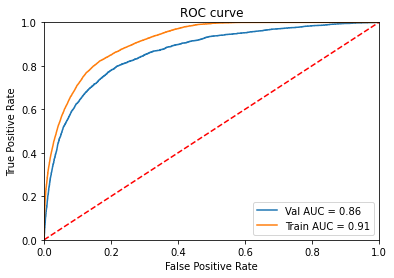

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished


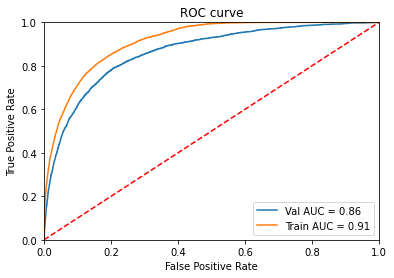

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished


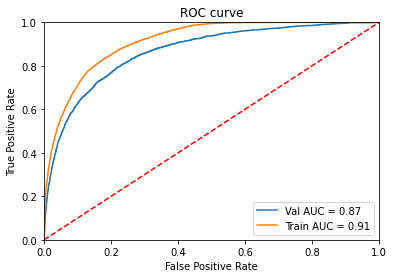

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.9s finished


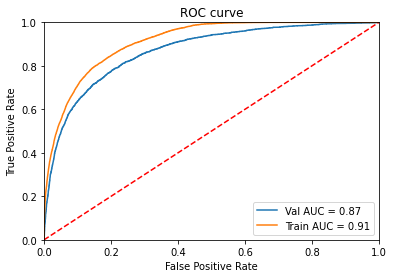

Mean of the Training AUC after k-fold cross validation is: 0.9131672644831362
Mean of the Val AUC after k-fold cross validation is: 0.8650462769405978


In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

kf = StratifiedKFold(n_splits=4)

auc=[]
auc_train=[]
for train_index, test_index in kf.split(features,labels):
  rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_samples=5000, verbose=1, max_features='sqrt')
  gbc = GradientBoostingClassifier(n_estimators=200,max_features='sqrt')
  eclf1 = VotingClassifier(estimators=[('rf', rf), ('gbc', gbc)], voting='soft')

  features_train, features_test = features[train_index], features[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]
  oversample = RandomOverSampler(sampling_strategy='minority')
  features_train_oversampled, labels_train_oversampled = oversample.fit_resample(features_train, labels_train)
    
  eclf1.fit(features_train_oversampled, labels_train_oversampled)

  train_predictions = np.array(eclf1.predict_proba(features_train_oversampled)[:,1])
  fpr_train, tpr_train, thresholds_train = metrics.roc_curve(labels_train_oversampled, train_predictions)
  roc_auc_train=metrics.auc(fpr_train, tpr_train)
  auc_train.append(roc_auc_train)

  predictions = np.array(eclf1.predict_proba(features_test)[:,1])
  fpr, tpr, thresholds = metrics.roc_curve(labels_test, predictions)
  roc_auc=metrics.auc(fpr, tpr)
  auc.append(roc_auc)

  plt.title('ROC curve')
  plt.plot(fpr, tpr, label = 'Val AUC = %0.2f' % roc_auc)
  plt.plot(fpr_train,tpr_train,label='Train AUC = %0.2f' % roc_auc_train)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

print("Mean of the Training AUC after k-fold cross validation is:", np.mean(auc_train))
print("Mean of the Val AUC after k-fold cross validation is:", np.mean(auc))

In [21]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_samples=5000, verbose=1, max_features='sqrt')
gbc = GradientBoostingClassifier(n_estimators=200,max_features='sqrt')
eclf1 = VotingClassifier(estimators=[('rf', rf), ('gbc', gbc)], voting='soft')
eclf1.fit(features_os,labels_os)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   18.3s finished


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=5000,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

# RESULTS OF VOTING CLASSIFIER 
1. Impute test data median into the test set - AUC of 0.86836 (Ranked around 40)
2. Impute training data median into test set - AUC of 0.86766 (Ranked between 60-70)

In [24]:
test_features= testing_df.drop('SeriousDlqin2yrs', axis = 1)
test_features = np.array(test_features)
final_predictions=np.array(eclf1.predict_proba(test_features)[:,1])
print(final_predictions)
final_df = pd.DataFrame(final_predictions, columns = ['Probability'])
final_df['Id'] = final_df.index + 1

final_df.to_csv('results.csv',index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.8s finished


[0.46886067 0.41689441 0.13288218 ... 0.04086487 0.58713316 0.37464501]


# VALIDATION TO DECIDE MODEL

1. As explained earlier, I used StratifiedKFold Validation with 4 splits.
2. As can be seen in the above plots - in the case of RandomForest, the training auc is very high while the validation auc is lower than GradientBoosting and VotingClassifiers.
3. In case of GradientBoosting, the training auc is lower than that of RandomForest or VotingClassifier, but the validation auc is higher than that of RandomForest.
4. For VotingClassifier, the training auc is higher than GradientBoosting and lower than RandomForest but the validation auc is the highest for VotingClassifier.
5. Since VotingClassifier gives the highest validation AUC, I chose this for the final model and as expected, it performs the best on the final test set as well.
